## Time to get your hands dirty. Galaxies vs quasars with neural networks.

Let's go back to our galaxy vs quasar data we've used in a previous exercise. 

1. Read in SDSS galaxy color data from `solutions/galaxyquasar.csv`. Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 

2. Now we're going to fit a neural network classifier. First, scale your data appropriately and do a 30% train/test split.

3. Now train the classifier. Use one the package among those we've seen. These include Tensorflow via keras, pytorch, and the MPL classifier implemented in scikit-learn. This is an opportunity to pick the one you're most interested in learning. 

3. Start from a network architecture with a single hidden layer with 5 neurons, using the `adam` solver, the `relu` activation function, and a learninig rate of `0.001`. Plot the resulting ROC curve. 


In [35]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import random
import pandas as pd
import corner
from sklearn.model_selection import train_test_split
import deepdish
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import roc_curve, auc
import keras_tuner

plt.rc('text', usetex=True)  # Abilita l'uso di LaTeX in tutte le stringhe di testo
plt.rc('font', family='serif')

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
df = pd.read_csv('../solutions/galaxyquasar.csv')

In [3]:
df

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [4]:
ug = np.array(df['u']-df['g'])
gr = np.array(df['g']-df['r'])
ri = np.array(df['r']-df['i'])
iz = np.array(df['i']-df['z'])

labels = np.where(df['class'] == 'QSO', 1, 0)

In [54]:
ug_scaled = ug/np.max(ug)
gr_scaled = ug/np.max(gr)
ri_scaled = ug/np.max(ri)
iz_scaled = ug/np.max(iz)

X = np.column_stack((ug_scaled, gr_scaled, ri_scaled, iz_scaled))
X_train, X_test, lab_train, lab_test = train_test_split(X, labels, test_size=0.3, random_state=7)

In [64]:
def trainnetwork(train_gal, train_lab, test_gal, test_lab, filename='trained.h5'):

    if not os.path.isfile(filename):

        train_in  = train_gal
        train_out = train_lab
        test_in  = test_gal
        test_out = test_lab

        # Kernel initializer
        my_init = keras.initializers.glorot_uniform(seed=1)
        
        # Define neural network architecture
        model = keras.Sequential([
            # Input layer
            tf.keras.layers.InputLayer(input_shape=np.shape(train_in[0])),
            
            # Hidden layer
            keras.layers.Dense(5, activation='relu', kernel_initializer=my_init),
            
            # Output layer
            keras.layers.Dense(1, activation='sigmoid', kernel_initializer=my_init)
        ])

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        # Actual Training with shorter output
        history = model.fit(
            train_in,             # Training inputs
            train_out,            # Training outputs
            validation_data=(test_in, test_out), # Validation data
            batch_size=20,        # Batch size
            epochs=150,           # Number of epochs
            callbacks=[
                tf.keras.callbacks.ModelCheckpoint(
                    filepath=filename,
                    save_weights_only=False,
                    monitor='val_accuracy',
                    mode='max',
                    save_best_only=True),
                tf.keras.callbacks.TensorBoard(log_dir="logs" + filename.split('.h5')[0], histogram_freq=1)
            ],
            shuffle=True,
            verbose=0            # Shorter output, displays epoch number and summary per epoch
        )

    model = loadnetwork(filename)
    return model

def loadnetwork(filename,verbose=False):
    '''
    Load a trained neural network ()
    '''

    model = tf.keras.models.load_model(filename)
    if verbose:
        model.summary()

    return model

def testnetwork(model,test_gal,test_lab):
   '''
   Test network on a series of galaxies
   '''
   test_in  = test_gal
   test_out = test_lab
   model.evaluate(test_in,  test_out, verbose=2)


def predictnetwork(model, test_gal):
    '''
    Use a network to predict the detectability of a set of galaxies.
    '''
    # Return the class (0 or 1) that is preferred
    predictions = np.squeeze((model.predict(test_gal) > 0.5).astype("int32"))
    return predictions


def plot_roc_curve(model, test_gal, test_lab):
    '''
    Plot the ROC curve for the given model and test data.
    Calls predictnetwork to get predicted probabilities.
    '''
    pred_probabilities = predictnetwork(model, test_gal)
    
    fpr, tpr, thresholds = roc_curve(test_lab, pred_probabilities)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guessing
    plt.xlim([0.0, 0.1])
    plt.ylim([0.8, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

In [18]:
trainnetwork(X_test, lab_test, X_train, lab_train,filename='trained.h5')

In [19]:
model = loadnetwork('trained.h5')

In [20]:
testnetwork(model, X_test, lab_test)

469/469 - 2s - loss: 0.0719 - accuracy: 0.9807 - 2s/epoch - 3ms/step


469/469 [==============================] - 1s 3ms/step


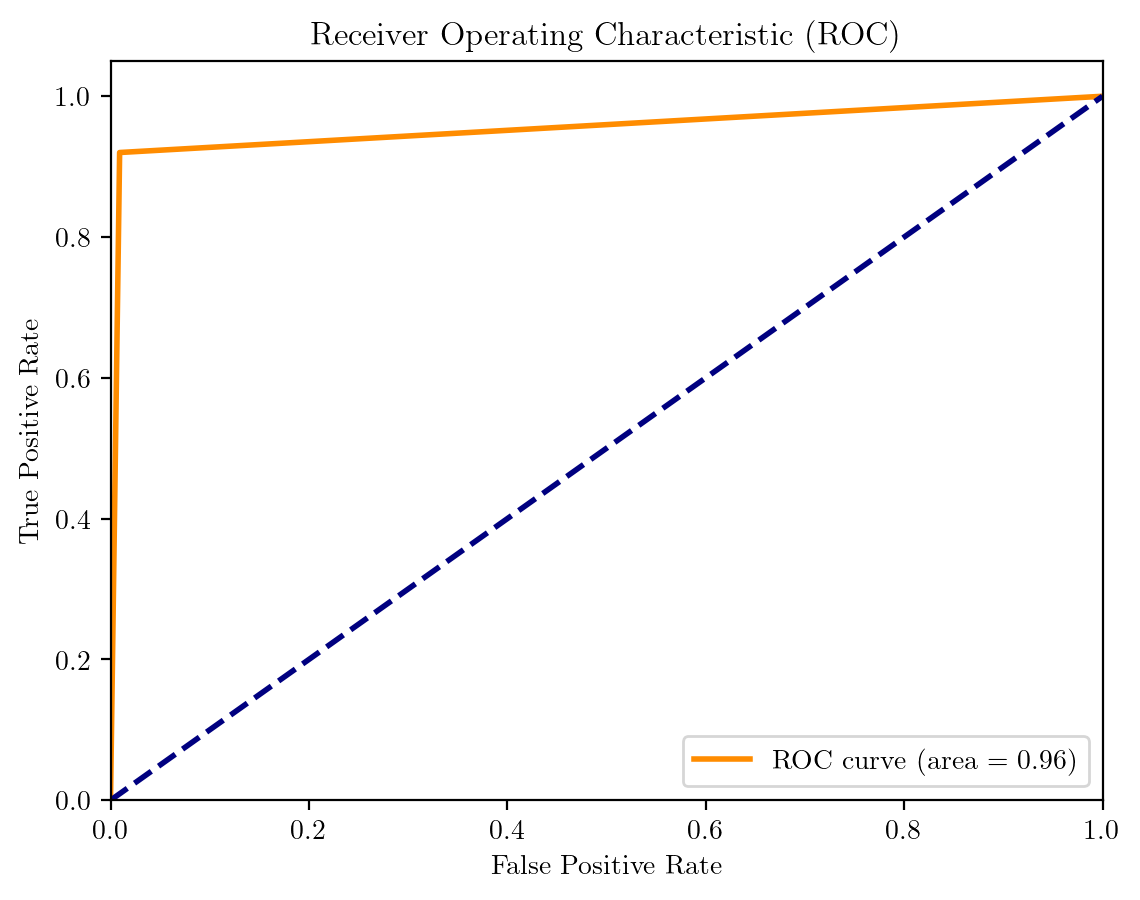

In [32]:
plot_roc_curve(model, X_test, lab_test)

In this case the performance is worse than the KNeighbors Classifiers used in the ex. of lecture 19, anyway it's very close and I haven't tuned anything yet

4. Now let's optimize the hyperparameters of your network. Explore different hyperparameters and see what fits the data best.  Do your best now to optimize the network architecture. Be creative!

5. Is your best result comparable with the simpler classifiers we've seen before? Do we need deep learning here? If yes, which features are captured best?


A few tips:

- In scikit-learn, remember that you can utilize all availables cores on your machine with `n_jobs=-1`. Print out the classification score for the training data, and the best parameters obtained by the cross validation.
- If it takes too long, run the hyperparameter optimization on a subset of the training set. Then retrain the full network using the best hyperparameters only.
- On cross validation, for scikit learn we've seen how to use `GridSearchCV` already. For Tensorflow, there's a really cool tool called [Tensorboard](https://www.tensorflow.org/tensorboard)

## Optimization of the hyperparameters

In [40]:
#divide the train in real train and validation
X_t, X_val, lab_t, lab_val = train_test_split(X_train, lab_train, test_size=0.4, random_state=7)

In [56]:
def build_model(hp):
    model = keras.Sequential()
    
    num_layers = hp.Int('num_layers', min_value=1, max_value=3, step=1)  # Optimize number of layers (1 to 3)
    
    for i in range(num_layers):
        # Choose number of neur for layer
        units = hp.Choice('units_' + str(i), [5, 6, 7, 10, 15, 20])
        # Choose act funct for layer
        activation = hp.Choice('activation_' + str(i), ['relu', 'tanh', 'sigmoid'])
        
        model.add(keras.layers.Dense(units, activation=activation))
    
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='mse', optimizer='adam')  # for now I'll keep adam
    return model

tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=220,
    executions_per_trial=2
)

# Perform the search
tuner.search(X_t, lab_t, epochs=10, validation_data=(X_val, lab_val))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]


Trial 220 Complete [00h 00m 59s]
val_loss: 0.015737177804112434

Best val_loss So Far: 0.015456310473382473
Total elapsed time: 20h 07m 26s


In [57]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:")
for key, value in best_hp.values.items():
    print(f"{key}: {value}")

Best hyperparameters:
num_layers: 3
units_0: 7
activation_0: relu
units_1: 7
activation_1: tanh
units_2: 15
activation_2: relu


## Fit with all train with the best model and then test

In [72]:
def bestnetwork_train(train_gal, train_lab, test_gal, test_lab, filename='trained.h5'):

    if not os.path.isfile(filename):

        train_in  = train_gal
        train_out = train_lab
        test_in  = test_gal
        test_out = test_lab

        # Kernel initializer
        my_init = keras.initializers.glorot_uniform(seed=1)
        
        # Define neural network architecture
        model = keras.Sequential([
            # Input layer
            tf.keras.layers.InputLayer(input_shape=np.shape(train_in[0])),
            
            # Hidden layer
            keras.layers.Dense(7, activation='relu', kernel_initializer=my_init),

            # Hidden layer
            keras.layers.Dense(7, activation='tanh', kernel_initializer=my_init),
            
             # Hidden layer
            keras.layers.Dense(15, activation='relu', kernel_initializer=my_init),
            
            # Output layer
            keras.layers.Dense(1, activation='sigmoid', kernel_initializer=my_init)
            
        ])

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        history = model.fit(
            train_in,             # Training inputs
            train_out,            # Training outputs
            validation_data=(test_in, test_out), # Validation data
            batch_size=40,        # Batch size
            epochs=50,           # Number of epochs
            callbacks=[
                tf.keras.callbacks.ModelCheckpoint(
                    filepath=filename,
                    save_weights_only=False,
                    monitor='val_accuracy',
                    mode='max',
                    save_best_only=True),
                tf.keras.callbacks.TensorBoard(log_dir="logs" + filename.split('.h5')[0], histogram_freq=1)
            ],
            shuffle=True,
            verbose=0            # Shorter output, displays epoch number and summary per epoch
        )

    model = loadnetwork(filename)
    return model


In [74]:
bestnetwork_train(X_test, lab_test, X_train, lab_train,filename='trained_best2.h5')

In [75]:
model = loadnetwork('trained_best2.h5')

In [76]:
testnetwork(model, X_test, lab_test)

469/469 - 1s - loss: 0.0717 - accuracy: 0.9808 - 1s/epoch - 2ms/step


469/469 [==============================] - 1s 2ms/step


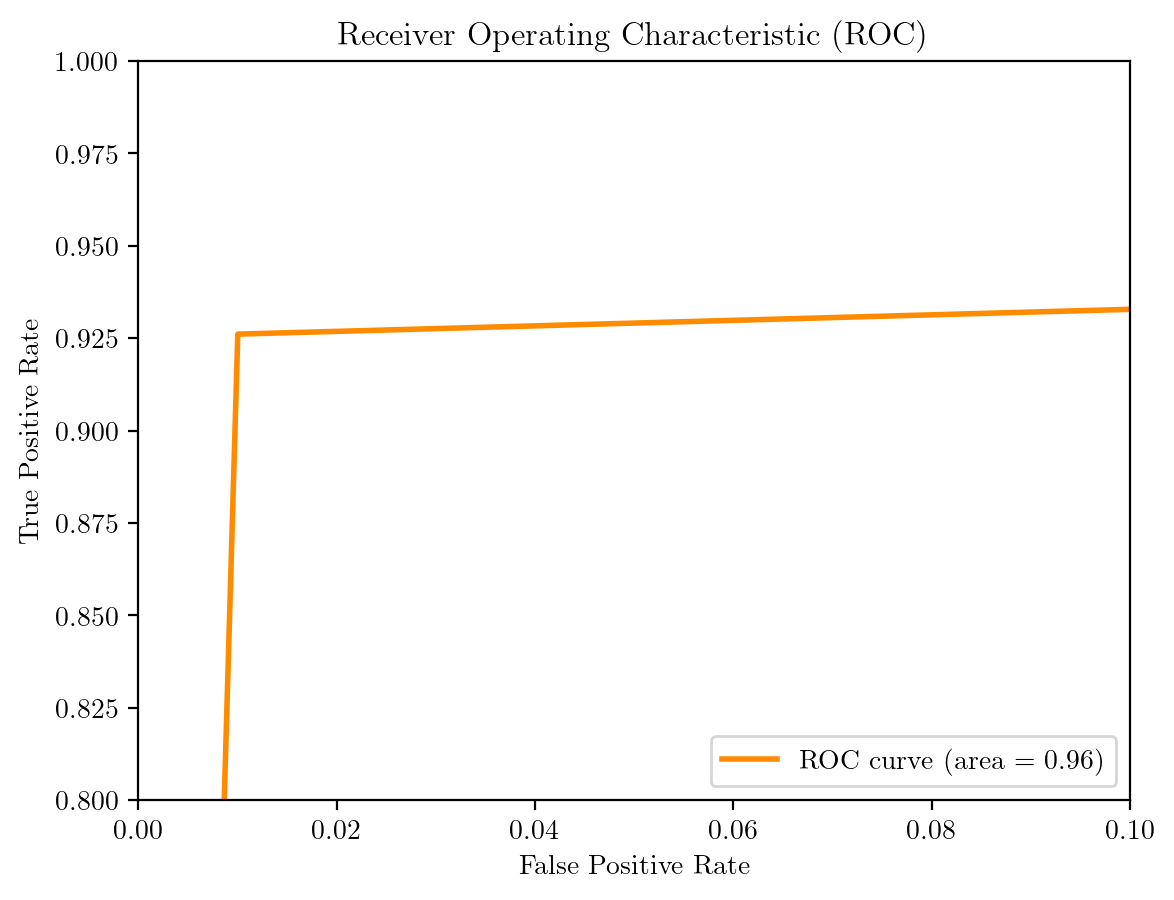

In [77]:
plot_roc_curve(model, X_test, lab_test)

Even with a selection of the best NN strategy I have the feeling that I got the same result of some of the strategies